In [1]:
# Code to plot the AWG response. 
# Pradip Gatkine (24 Feb 2021)

import numpy as np;
import matplotlib.pyplot as plt
from astropy.io import fits
import math
from scipy.optimize import curve_fit
import glob
import os
import sys
import matplotlib.backends.backend_pdf
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from scipy import linalg
import pprint


import re
plt.rc('font', family='serif')
from matplotlib import rc
import pandas as pd


#rc('font', **{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

# Import File

In [2]:
# Importing the data file here. You can also simply use the name of the file here.
# This assumes that the data file is in the same folder as the code. If not, please add the relative or full path of the file
# This import statement works in Linux. A different library/statement maybe needed for Windows
#print ("Current working dir : S%s" % os.getcwd())
File_list = sorted(glob.glob("*.dat"))
for file in range(len(File_list)):
    File_list[file] = os.getcwd() + "\\" + File_list[file]
pprint.pprint(File_list)

['C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\Res1k_TE_Phase_Err_0.dat']


In [3]:
file_num = 0
chan_num = 13 # This is the number of channels in the AWG. For higher resolution AWGs, this number will be higher.
              # You could also simply find the number of columns in the data and determine the number of channels. 
a = np.arange(0, chan_num+1)
a_string = [str(a_i) for a_i in a] 
df = pd.DataFrame()
df = pd.read_csv(File_list[file_num], sep="\s+", names=a_string)
for ind in a_string[1:]:
    df[ind] = 10*np.log10(df[ind])
df['0'] = 1000*df['0']  # df['0'] is wavelength in micron, multiplying by 1000 to convert to nm.

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1518.225000,-58.525701,-54.671896,-54.415431,-57.261132,-48.621739,-27.542934,-1.674947,-27.542934,-48.621742,-57.261095,-54.415431,-54.671769,-58.525775
1,1518.289583,-58.525701,-54.671896,-54.415431,-57.261132,-48.621739,-27.542934,-1.674947,-27.542934,-48.621742,-57.261095,-54.415431,-54.671769,-58.525775
2,1518.354167,-58.525701,-54.671896,-54.415431,-57.261132,-48.621739,-27.542934,-1.674947,-27.542934,-48.621742,-57.261095,-54.415431,-54.671769,-58.525775
3,1518.418750,-58.525701,-54.671896,-54.415431,-57.261132,-48.621739,-27.542934,-1.674947,-27.542934,-48.621742,-57.261095,-54.415431,-54.671769,-58.525775
4,1518.483333,-58.525701,-54.671896,-54.415431,-57.261132,-48.621739,-27.542934,-1.674947,-27.542934,-48.621742,-57.261095,-54.415431,-54.671769,-58.525775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,1559.816667,-8.013770,-37.500060,-64.897441,-49.474692,-52.351693,-54.609351,-52.292071,-52.653039,-54.360324,-53.928756,-55.510825,-47.110866,-23.438925
645,1559.881250,-8.827469,-39.368273,-61.938130,-49.195380,-52.603066,-54.766917,-52.193044,-52.958395,-54.826350,-53.349001,-56.716359,-46.816968,-21.587701
646,1559.945833,-9.745225,-41.406588,-60.278128,-49.111147,-52.997867,-54.849464,-52.138185,-53.271204,-55.208465,-52.796803,-57.542710,-46.983646,-19.815234
647,1560.010417,-10.768259,-43.032119,-59.854118,-49.252442,-53.529308,-54.828829,-52.068439,-53.591695,-55.466202,-52.222053,-58.780592,-47.094139,-18.136651


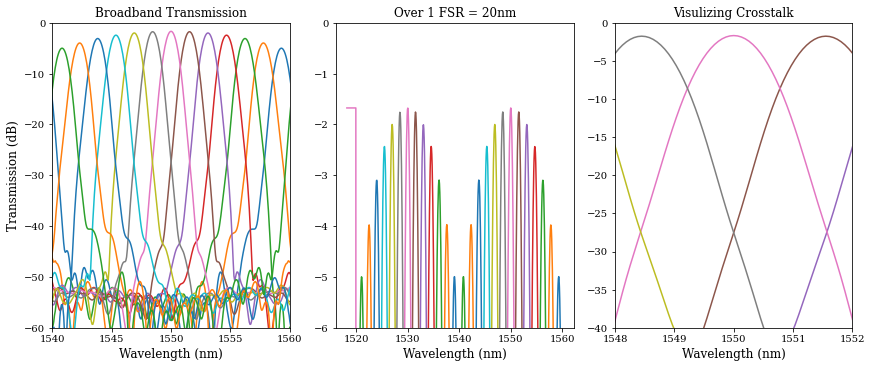

In [5]:
#plt.figure()
#fig, ax = plt.subplots() # plt.subplots(figsize=(15,8))
#plt.plot(range(len(df['0'])), df['0'])
#done defining the Emission_line object!
fig3 = plt.figure(constrained_layout=True, figsize=(12,5))
gs = fig3.add_gridspec(1, 3) #creates grid with one row and 3 columns
f3_ax1 = fig3.add_subplot(gs[0, 0])
f3_ax1.set_title('Broadband Transmission')
f3_ax2 = fig3.add_subplot(gs[0, 1])
f3_ax2.set_title('Over 1 FSR = 20nm')
f3_ax3 = fig3.add_subplot(gs[0, 2])
f3_ax3.set_title('Visulizing Crosstalk')
'''
So how do I display a rectangular signal? For a spectral range 
of .1 nanometer, have a constant signal! 
Let's write this very generally so it's easier to adapt for 
more complicated exercises. So for each wavelength range we have
1 dB = 10log_{10}(P/P_0). We want constant source power over a wavelength 
range of 1 angstrom. 
Since we're in the NIR instead of X ray, you don't need to worry about
individual photons as a function of wavelength.
dBm when the reference power is a single milliwatt. dBW is when the 
reference power is a single watt.
'''
#source_signal = [0]*649
stepsize = df.iloc[0,0]-df.iloc[1,0]
df.plot(x='0', legend=0, ax = f3_ax1)
#plotting!
f3_ax1.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax1.set_ylabel('Transmission (dB)', fontsize=12)
f3_ax1.set_xlim(1518, 1560)
#f3_ax1.set_xlim(1518, 1560)
f3_ax1.set_ylim(-60, 0)

df.plot(x='0', legend=0, ax = f3_ax2)
#plotting!
f3_ax2.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax1.set_xlim(1540, 1560)
#f3_ax2.set_xlim(1540, 1560)
f3_ax2.set_ylim(-6, 0)

df.plot(x='0', legend=0, ax = f3_ax3)
#plotting!
f3_ax3.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax3.set_xlim(1548, 1552)
f3_ax3.set_ylim(-40, 0)

File_in = File_list[file_num]
File_out = File_in[:-4]
plt.savefig(File_out + '.pdf')
plt.show()

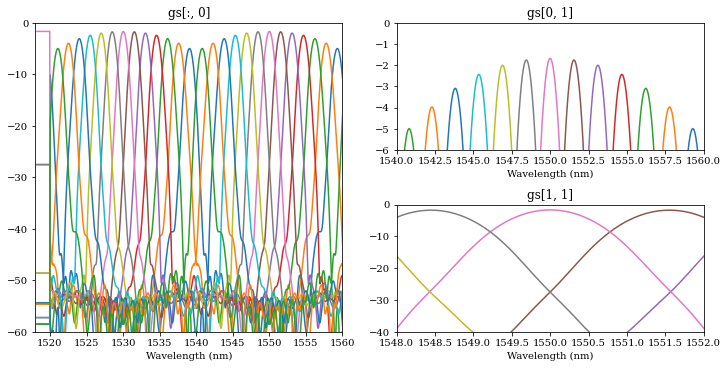

In [6]:
#plt.figure()
#fig, ax = plt.subplots() # plt.subplots(figsize=(15,8))

fig3 = plt.figure(constrained_layout=True, figsize=(10,5))
gs = fig3.add_gridspec(2, 2)
#What does this mean/do??
f3_ax1 = fig3.add_subplot(gs[:, 0])
f3_ax1.set_title('gs[:, 0]')
f3_ax2 = fig3.add_subplot(gs[0, 1])
f3_ax2.set_title('gs[0, 1]')
f3_ax3 = fig3.add_subplot(gs[1, 1])
f3_ax3.set_title('gs[1, 1]')


df.plot(x='0', legend=0, ax = f3_ax1)
#plotting!
f3_ax1.set_xlabel('Wavelength (nm)')
f3_ax1.set_xlim(1518, 1560)
f3_ax1.set_ylim(-60, 0)

df.plot(x='0', legend=0, ax = f3_ax2)
f3_ax2.set_xlabel('Wavelength (nm)')
f3_ax2.set_xlim(1540, 1560)
f3_ax2.set_ylim(-6, 0)

df.plot(x='0', legend=0, ax = f3_ax3)
f3_ax3.set_xlabel('Wavelength (nm)')
f3_ax3.set_xlim(1548, 1552)
f3_ax3.set_ylim(-40, 0)
plt.show()

## ---------- Upto this part is relevant for Marcos for now ---------------------

# Plot 3-dB width

In [7]:
# Reference: 
# Peaks: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
# Peak widths: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_widths.html#scipy.signal.peak_widths

# Finding 3-dB width of the AWG peaks.
from scipy.signal import chirp, find_peaks, peak_widths

def find_3dB_width(lam, op_power_norm_fib, FSR):
    d_lam = lam[1]-lam[0]
    FSR_chunk = np.int(0.8*FSR/d_lam) # Taking 80% of the FSR as the minimum distance between the peaks
    #Consider the 13th channel. A distance of .8*FSR would use peaks from the next spectral order.
    op_power_norm_fib_lin = np.power(10.0,  op_power_norm_fib/10) # converting to linear scale for peak-width measurement

    peaks, _ = find_peaks(op_power_norm_fib_lin, height = .1, distance=FSR_chunk)
    #find_peaks is defind in scipy. You can use it to place the emission lines! Get the array from here
    results_half = peak_widths(op_power_norm_fib_lin, peaks, rel_height=0.5)  # rel_height = 0.5 => FWHM  (half-power beam width)
    #you can define offsets in terms of the FWHM named results_half
    return peaks, lam[peaks], op_power_norm_fib[peaks], d_lam*results_half[0], d_lam  # The zeroth element is width

In [8]:
# Marcos Perez being mentored by Pradip Gatkine (14 June 2021)
'''
The class calculates what rows in the dataframe are spanned by an emission line
given its shape, width, and height!

I don't assume the center, or boundaries of the emission line fall on the 
exact wavelengths listed in the first column of the dataframe.

The class Emission_line defines the relevant indices in the dataframe given 
the center-nanometers and width (or alternatively the left_boundary and right_boundary).
If its symmetrical, the input for the left_boundary and right_boundary will be 
disregarded.

Width is the full width of the emission line, not the half width, nor the FWHM. 

So the attributes of the class are: 
self.center_index, self.center_nanometers, self.width_nanometers, self.height, self.shape, 
self.symmetrical  self.center_index, self.smallest_nanometers, self.largest_nanometers, 
self.smallest_index, self.largest_index, self.width_indices, self.row_indices_spanned, 
self.source_power, and self.integrated_power. 
It's recommended that  self.row_indices_spanned be used to find the relevant rows in the array.

For Gaussian emission lines, the standard deviation is taken to be 1/6 of the full width
of the emission line. Full widths less than twice the wavelength increment (here it's approximately 1.5 nm)
should be called as rectangular emission lines.

To plot the simulated measurement of multiple emission lines, add the arrays each named
self.integrated_power.
'''
class Emission_line:
   
     #now to find the closest row to the desired center_nanometers
    def __init__(self, center_nanometers, width_nanometers, height, shape, symmetrical, 
                    left_boundary, right_boundary):
        #center_index is the index of the center row of the emission line based on its wavelength
        #Will be calculated later
        self.center_index = 0
        self.center_nanometers = center_nanometers
        self.width_nanometers = width_nanometers 
        self.height = height 
        self.shape = shape 
        self.symmetrical = symmetrical
        if(not symmetrical and (left_boundary and right_boundary)):
            self.left_boundary = left_boundary
            self.right_boundary = right_boundary
        #Find the what row best corresponds to the wavelength of the center of the emission line
        for index in list(range(df.shape[0])):
            if (df.iloc[index,0] == center_nanometers or df.iloc[index,0] > center_nanometers):
                '''
                if there is no wavelength exactly equal to the center we choose the 
                smallest index greater than the desired center. The same will be done for the 
                left boundary (smallest_nanometers) of the emission line. For the right boundary 
                (largest_nanometers) of the emission line, we will instead choose the largest 
                wavelength in the dataframe smaller than the right boundary. 
                '''
                center_index = index
                break
        try: 
            width_indices  = 1
            smallest_index = 0
            largest_index = df.shape[0]-1
            if(symmetrical):
                self.smallest_nanometers = center_nanometers - (.5*width_nanometers)
                self.largest_nanometers = center_nanometers + (.5*width_nanometers)
            else:
                self.smallest_nanometers = left_boundary
                self.largest_nanometers = right_boundary
            left_range = list(range(0, center_index)) 
            left_range.reverse()
            #left_range is the range within which we'll search for the row with the smallest wavelength
            for index in left_range:
                if (df.iloc[index,0] == self.smallest_nanometers):
                    smallest_index = index
                    break
                elif (df.iloc[index,0] < self.smallest_nanometers):
                    smallest_index = index+1
                    break
            for index in list(range(center_index, df.shape[0])):
                 if (df.iloc[index,0] == self.largest_nanometers):
                    largest_index = index
                    break
                 elif (df.iloc[index,0] > self.largest_nanometers):
                    largest_index = index-1
                    break
            if (largest_index < smallest_index or largest_index == smallest_index):
                smallest_index, largest_index = largest_index, smallest_index
                width_indices = 1
                '''
                This can happen for < .1 nm emission lines that are exactly one of the ones in the row.
                '''
            else :
                width_indices = largest_index-smallest_index

            self.center_index = center_index
            #smallest_index is the index of the highest row of the emission line based on its wavelength
            self.smallest_index = smallest_index
            #largest_index is the index of the highest row of the emission line based on its wavelength
            self.largest_index = largest_index
            self.width_indices = width_indices
            #now we'll use these indices to define the array
            #Source_power is an array of the source signal's power at each wavelength. 
            source_power = np.empty(self.width_indices)
            #self.row_indices_spanned is a 1 dimensional array
            self.row_indices_spanned = np.array(list(range(smallest_index, largest_index+1)))

            if (self.shape == "Rectangular" or self.shape == "rectangular"):
                source_power = np.array([self.height]*self.width_indices)
                source_power = source_power/len(self.row_indices_spanned) 
                #This normalizes the emission line for different widths

            elif (self.shape == "Gaussian" or self.shape == "gaussian"):
                source_power = np.array([self.height]*self.width_indices)
                #here stan_dev is the standard deviation of the Gaussian for the emission line
                stan_dev = width_nanometers/6
                wavelengths = df.iloc[self.row_indices_spanned,0]
                #here cont_distr is the continuous distribution of the Gaussian for the emission line
                cont_distr = norm(center_nanometers, stan_dev)
                source_power = cont_distr.pdf(wavelengths)
                area_under_curve = np.trapz(source_power, wavelengths)
                #This normalizes the emission line for different widths
                if not (area_under_curve == 1):
                    if not (area_under_curve == 0):
                        source_power = source_power/area_under_curve                
                    else:
                        area_error_message = "Width of " + str(width_nanometers) + " is too small for a Gaussian"
                        area_error_message = area_error_message + " distribution in this dataframe."
                        area_error_message = area_error_message + " Please use rectangular shape."
                        print(area_error_message)

            self.source_power = source_power
            #It's recommended that  self.row_indices_spanned be used to find the relevant rows in the array
            self.power_transmitted = np.empty(len(self.source_power))
            #We will express everything in arbitary power units
        except (NameError, ValueError):
            error_message = "Wavelength of " + str(np.around(center_nanometers, 4)) + " nanometerss"
            error_message =  error_message + " is longer than any wavelength listed in the dataframe"
            error_message = error_message + "\nor the emission line has at least one other invalid argument"
            print(error_message)        

    def calculate_power_vs_channels(self, channels):   
        '''
        Now let's plot just power vs channel. So we have the transmission in dB, 
        let's convert that to a power in arbitrary power units then sum across 
        each wavelength spanned by each spectral channel in the arrayed waveguide grating (AWG)
        '''
        '''
        In this function, wavelength is an index, not the wavelength in nanometerss.
        Each element in the source_power array corresponds to a different wavelength, 
        hence the name wavelength
        '''
        rows_spanned = self.row_indices_spanned
        try:
            integrated_power = np.empty(len(channels))
            for channel in (channels):
                transmission = df.iloc[rows_spanned, channel]
                transmission = transmission.to_numpy() #necesssary because it can return a pandas.Series instead
                for wavelength in range(len(self.source_power)): 
                    self.power_transmitted[wavelength] = np.power(10.0,(transmission[wavelength]/10))
                    #based on our definition of transmission
                    self.power_transmitted[wavelength] = self.power_transmitted[wavelength]*self.source_power[wavelength]
                integrated_power[channel-1] = self.power_transmitted.sum()
                
        except TypeError: #this should only run if the transmission from a single channel is being simulated
            print("Only channel " + channel + " is included in the integrated power")
            transmission = df.iloc[rows_spanned, channels]
            transmission = transmission.to_numpy() #necesssary because it can return a pandas.Series instead
            for wavelength in range(len(self.source_power)): 
                    self.power_transmitted[wavelength] = np.power(10.0,(transmission[wavelength]/10))
                    #based on our definition of transmission
                    self.power_transmitted[wavelength] = self.power_transmitted[wavelength]*self.source_power[wavelength]
            integrated_power = self.power_transmitted.sum()

        self.integrated_power = integrated_power
        
test = Emission_line(1540, 0.1, 1, "Rectangular", True, 0, 0)

In [66]:
'''
We need to find the peak wavelength of a channel to use as the center wavelength for 
the first emission line! We will use the find_peaks() function built into scipy and used by Pradip
in the find_3dB_width() function.
Then we will find the appropriate rows by initializing an Emission_line object. Then call the 
function I wrote in it named calculate_power_transmitted. We will call this function
with an array including each of the desired channels, then use the attribute named self.integrated_power
to plot each output!

All of the terms have the same definition as the in the Emission_line class. 
channels is just an array of the number of channels (1 indexed).
Remember, the 0th column is still the wavelengths, not the transmission in a channel.
plot_dict is a dictionary where the keys are are the plot colors and the values are
the plot handles
'''
 

def plot_power_vs_channels(center_nanometer, width_nanometer, height, shape, symmetrical, 
                    left_boundary, right_boundary, channels, plot_dict, is_dB, ax1):
    emission_line = Emission_line(center_nanometer, width_nanometer, height, shape, symmetrical, 
                    left_boundary, right_boundary)
    emission_line.calculate_power_vs_channels(channels)
    integrated_power = emission_line.integrated_power
    if(is_dB):    
        integrated_power = 10*np.log10(integrated_power)
    colors = list(plot_dict.keys())
    handles = list(plot_dict.values())
    for label in list(range(len(plot_dict))):
        ax1.scatter(channels, integrated_power, s=2, color = str(colors[label])) 
        #label = str(handles[label]), color = str(colors[label])
    '''
    The following code exports the plot to the current working directory
    path_title = "\\Simulated_Power_Transmitted_in_Each_Spectral_Channel\\"
    path_sub_title = "Single_Emission_Line"
    png_path = os.getcwd() + path_title + path_sub_title + ".png"
    pdf_path = os.getcwd() + path_title + path_sub_title + ".pdf"
    plt.savefig(png_path)
    plt.savefig(pdf_path)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_ylim(0,-60)
    '''
    ax1.grid(which='major', color='grey', alpha=0.25)
    xlabel = 'Channel Number'
    if(is_dB):    
        ylabel = 'Power in dB'
        ax1.set_ylim(-70, 0)
    else:
        ylabel = 'Power (arbitrary units)'
        plt.setp(ax1, yticks = np.array((np.linspace(0,1,11))))
        ax1.set_ylim(0,1)
    ax1.set_xlabel(xlabel, fontsize = 8)
    ax1.set_ylabel(ylabel, fontsize = 8)
    ax1.set_title(handles[0], fontsize = 8)
    plt.setp(ax1, xticks=np.array((range(1,14))), yticks = np.array((range(-60,10,10))))
    ax1.tick_params(axis='x', which='major', labelsize= 5)
    ax1.tick_params(axis='y', which='major', labelsize= 7)
    #legend(loc='upper center', bbox_to_anchor=(.5, -.15))
'''
Now we need to get the peaks!
The rest of this codeblock is just a test using the first channel.  
The next codeblock will include a for loop that progressses through 
all of the odd numbered channels
'''
lam = np.array(df['0'])
FSR = 20
op_power_norm_fib = np.array(df['1'])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
center_nanometer = peaks[1][0]
width_nanometer = .1 #1 angstrom
height = 1.0
shape = "rectangular"
symmetrical = True
left_boundary = 0
right_boundary = 0
channels = np.array(list(range(1,14)))
#Now we will make a dictionary to set the colors and labels for everything in the plot
labels = 1
plot_handles, plot_colors = [""]*labels, [""]*labels
plot_handles[0] =  str(width_nanometer) + " nanometer emission line centered at "
plot_handles[0] =  str(plot_handles[0]) +  str(np.around(center_nanometer, 4)) + " nanometers"
plot_colors[0] = 'blue'
plot_dict = {}
for i in range(len(plot_colors)):
    plot_dict[plot_colors[i]] = plot_handles[i]
    
#There are 13 channels but range will only go up to 1 before the second argument!
#plot_power_vs_channels(center_nanometer, width_nanometer, height, shape, symmetrical, left_boundary, right_boundary, channels, plot_dict, True)
#keep a set of plotting templates, formats and commands in place to copy and paste when needed
#We're in the initial steps of plotting, so keep the plotting commands floating rather than in a function
#Worry about additional plots once everything is set up

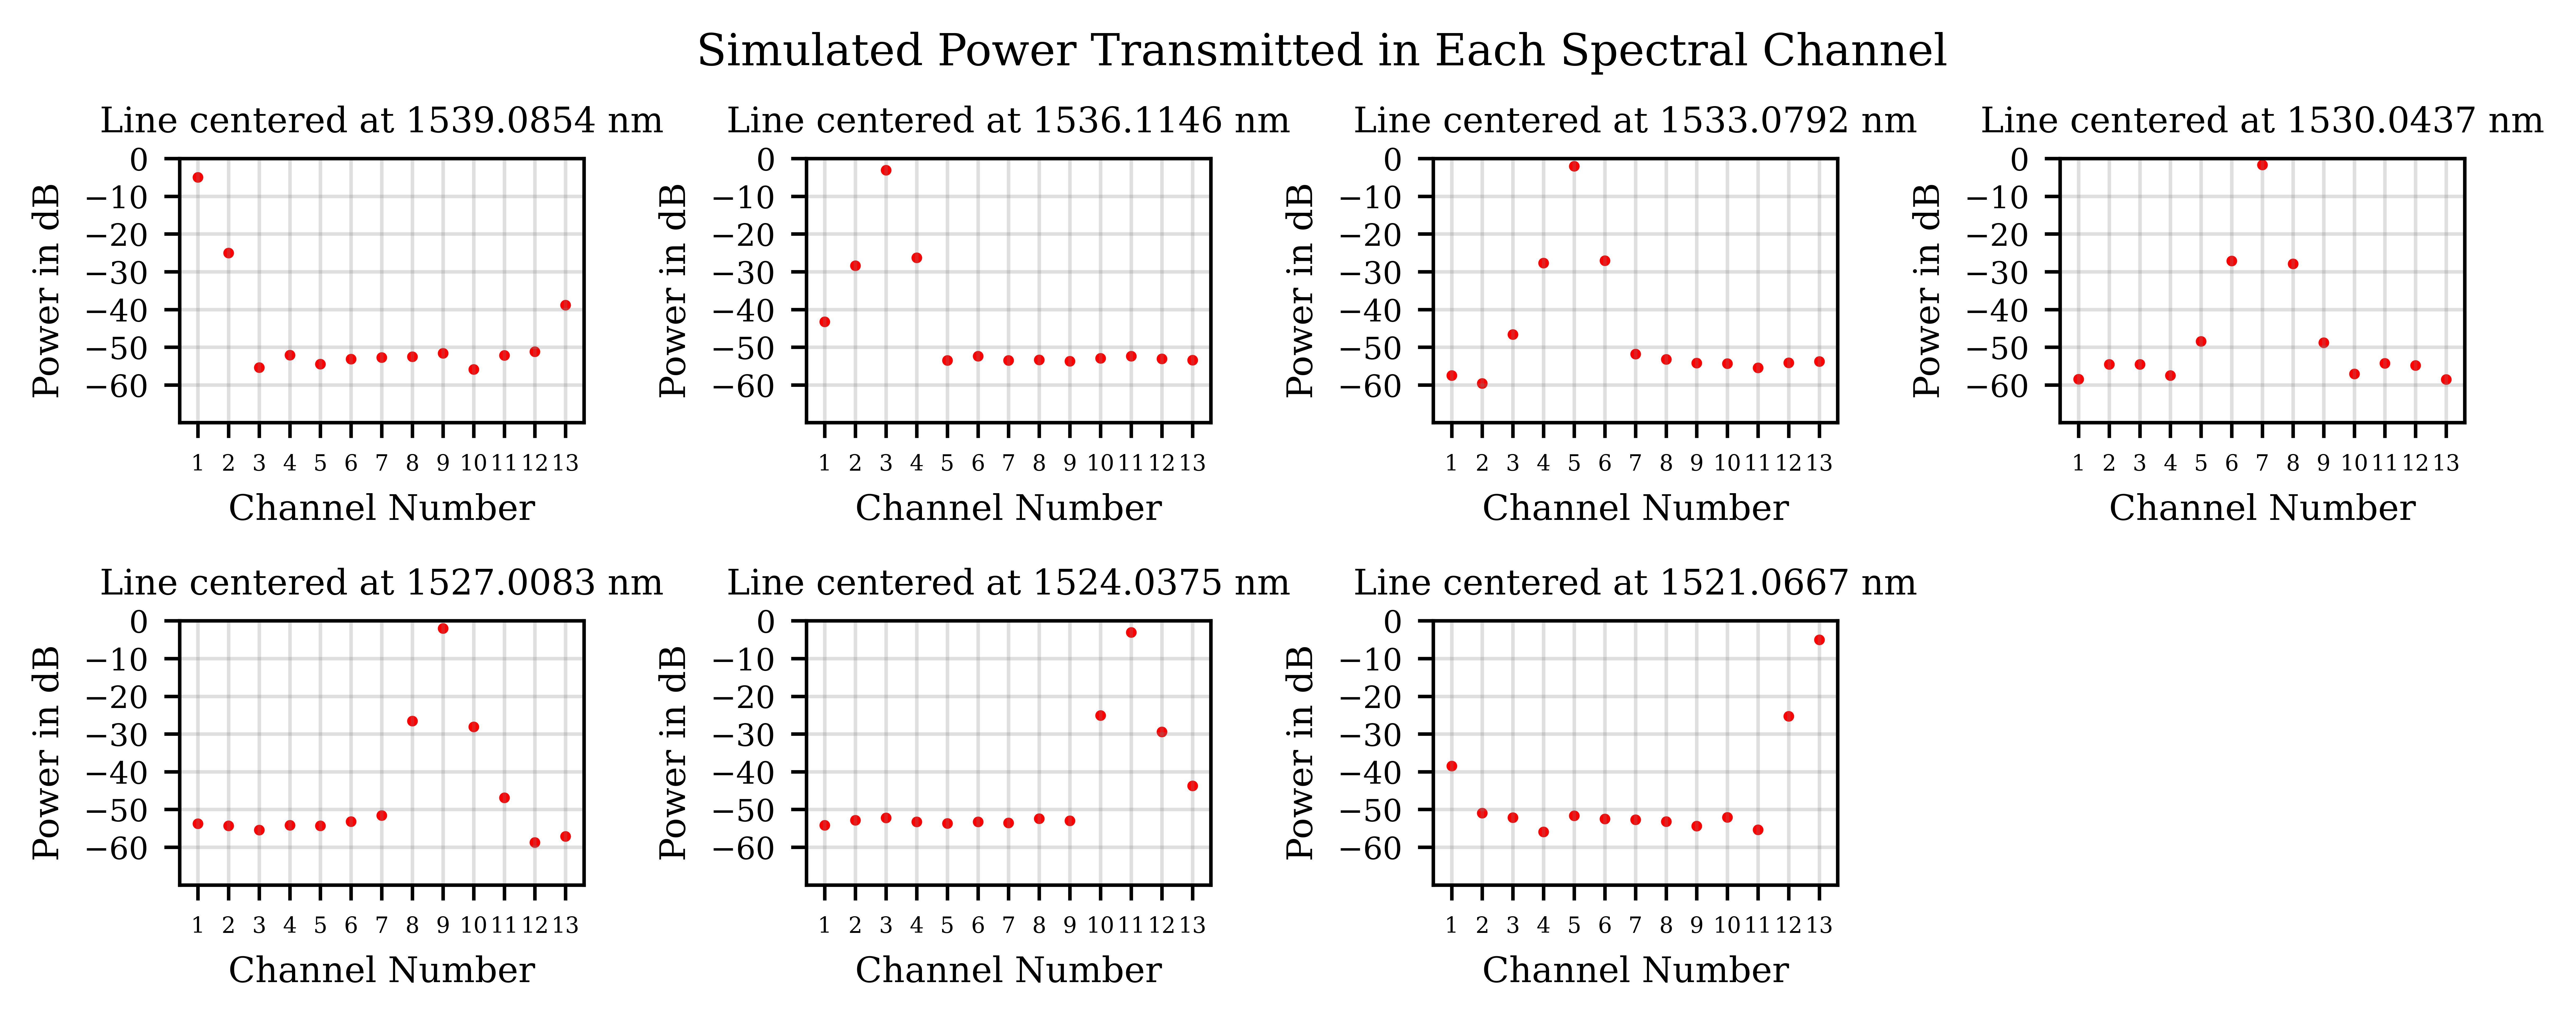

In [67]:
'''
let's make the same plot for emission lines centered at the peak of different 
channels! We will use emission lines centered at the peak of channels 1, 3, 5, 7, and 9.
'''

#fig.text(0.5, 0.04, 'Channel Number', ha='center', fontsize = 'small')
#fig.text(0.04, 0.5, 'Power in dB', va='center', rotation='vertical', fontsize = 'small')
lam = np.array(df['0'])
FSR = 20
offset = 0 #shifting the emission line to the right of the peak by this many nanometers

plt.figure(dpi=1200)
gs = gridspec.GridSpec(4, 4)
#This is so that we can have 7 plots each take up 2 rows 
plt.subplots_adjust(wspace = .55, hspace = .75)
plt.subplots_adjust(top=0.9, left = -.3, bottom = -.4)
plt.suptitle('Simulated Power Transmitted in Each Spectral Channel', x=.3, y = 1, fontsize=10)
for peak_channel in np.array((1, 3, 5, 7, 9, 11, 13)):
    plot_num = int(.5*(peak_channel-1))
    plot_indices = np.array((int(plot_num/4), plot_num%4))
    '''
    This two element array iterates through the subplot based on which channel we're choosing
    the peak wavelength from. 
    '''
    ax1 = plt.subplot(gs[plot_indices[0], plot_indices[1]])
    plt.setp(ax1, xticks=np.array((range(1,14))), yticks = np.array((range(-60,10,10))))
    ax1.tick_params(axis='x', which='major', labelsize= 5)
    ax1.tick_params(axis='y', which='major', labelsize= 7)
    op_power_norm_fib = np.array(df[str(peak_channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    center_nanometer = peaks[1][0]+offset
    width_nanometer = .1 #1 angstrom
    height = 1
    shape = "rectangular"
    symmetrical = True
    left_boundary = 0
    right_boundary = 0
    channels = np.array(list(range(1,14)))
    #Now we will make a dictionary to set the colors and labels for everything in the plot
    labels = 1
    plot_handles, plot_colors = [""]*labels, [""]*labels
    plot_handles[0] =  "Line centered at " + str(np.around(center_nanometer, 4)) + " nm"
    plot_colors[0] = 'red'
    plot_dict = {}
    for i in range(len(plot_colors)):
        plot_dict[plot_colors[i]] = plot_handles[i]
    #There are 13 channels but range will only go up to 1 before the second argument!
    plot_power_vs_channels(center_nanometer, width_nanometer, height, shape, symmetrical, 
                        left_boundary, right_boundary, channels, plot_dict, True, ax1=ax1)
'''
caption = "Figure 1: The simulated power transmitted by the spectrograph after being dispersed by "
caption = caption + "the Arrayed Waveguide Grating (AWG)\n" + "when observing a rectangular"
caption = caption + " emission line with a full width of .1" + " nanometers (nm)."
caption = caption + " Each emission line is centered at " 
if(offset == 0):
    caption = caption + "\n"
else:
    caption = caption + "a\n" + "wavelength "+ str(offset) + " nm longer than " 
caption = caption + "the peak of an odd numbered channel" 
caption = caption + " (channels 1, 3, 5, 7, 9, 11, and 13, respectively)."
plt.text(x = -42, y = -145, s= caption, fontsize = 9)
'''
plt.show()

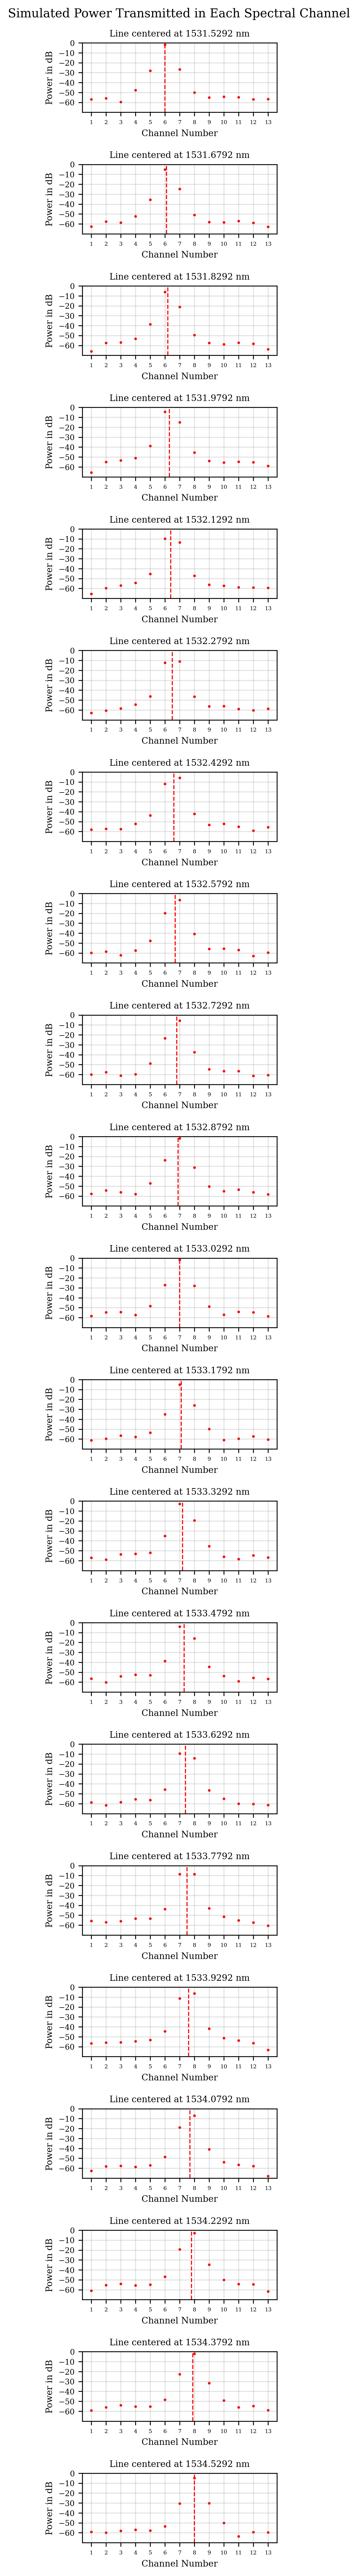

In [77]:
#CONTINUOUS OFFSET!
#now to increment the center wavelength by .15nm at a time between the centers of channels 6 and 7
#we'll have a for loop that creates an emission line by creating an instance of the Emission_line class
#num is the number of plots we're making
#the red vertical line is the center of the emission line
step_size = .15
num = int((3 / step_size)+1)
offset_range = np.linspace(0, 3, num)
lam = np.array(df['0'])
FSR = 20
starting_channel = 6
op_power_norm_fib = np.array(df[str(starting_channel)])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
center_nanometer = peaks[1][0]
labels = 1
plot_handles, plot_colors = [""]*labels, [""]*labels
width_nanometer = .1
height = num*2
channels = list(range(1,14))
plt.figure(figsize = [7, height], dpi=300)
gs = gridspec.GridSpec(num, 2, hspace=.75)
plt.suptitle('Simulated Power Transmitted in Each Spectral Channel', x=.3, y = 0.890625, fontsize=11)
for offset in offset_range:
    #current_num is the current column the graph will be in
    current_num = int(offset/step_size)
    ax1 = plt.subplot(gs[current_num, 0])
    plot_handles[0] =  "Line centered at " + str(np.around(center_nanometer+offset, 4)) + " nm"
    plot_colors[0] = 'red'
    plot_dict = {}
    line_x = starting_channel+(offset/1.5)
    ax1.axvline(x = line_x, linestyle='dashed', color = 'r', linewidth = 1)
    for i in range(len(plot_colors)):
        plot_dict[plot_colors[i]] = plot_handles[i]
    plot_power_vs_channels(center_nanometer-offset, width_nanometer, 1, "Rectangular", True, 
                    left_boundary, right_boundary, channels, plot_dict, is_dB, ax1)

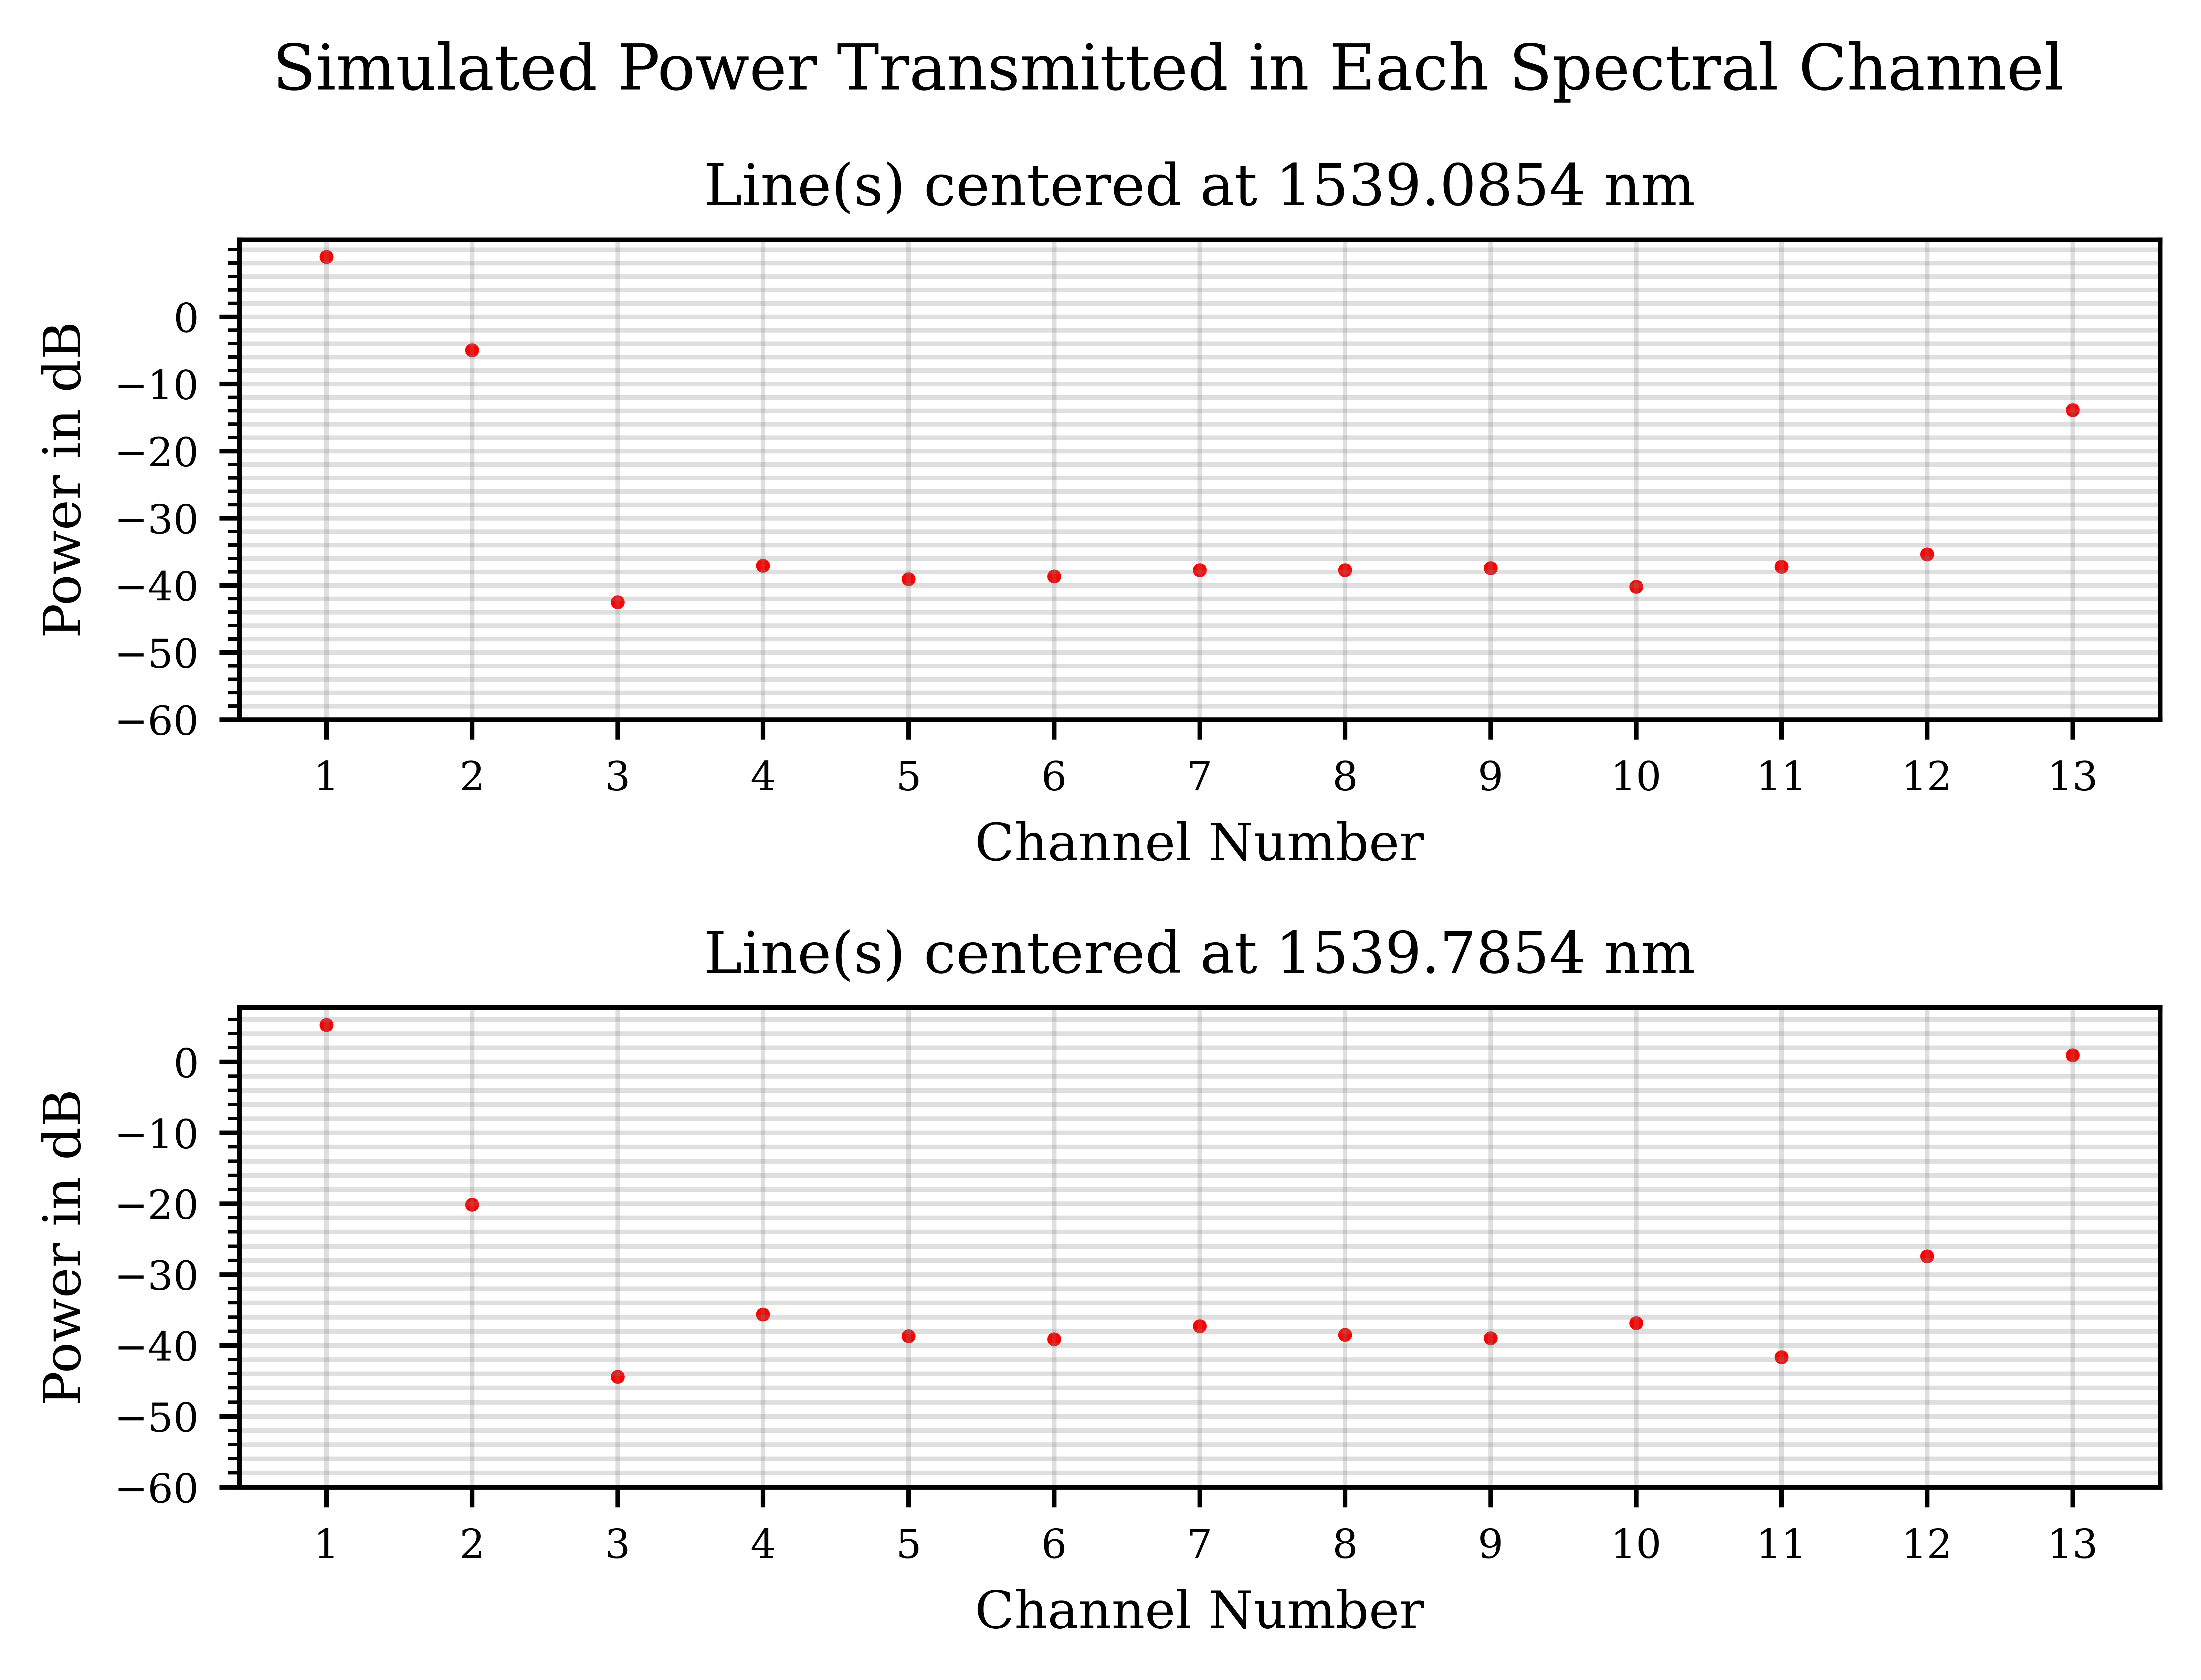

In [59]:
#Now let's plot the simulated measurement of multiple emission lines!
'''
#For randomly chosen emission lines
lam1 = df.sample() #this will return the row as a nested array
lam2 = df.sample() #Replace this with specific desired spectral lines afterwards
lam1 = lam1.to_numpy()
lam2 = lam2.to_numpy()
lam1 = lam1[0][0] #retrieving the wavelength from the nested array
lam2 = lam2[0][0]
'''
#plt.subplots_adjust(wspace = .55, hspace = 6.0)
lam = np.array(df['0'])
FSR = 20
op_power_norm_fib = np.array(df['1'])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
lam1 = peaks[1][0]
op_power_norm_fib = np.array(df['1'])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
lam2 = peaks[1][0]
center_nanometer = np.array((lam1, lam2))
width_nanometer = [2, 2]
height = [1, 0]
shape = ["Gaussian", "Gaussian"]
channels = list(range(1,14))
left_boundary, right_boundary = [0]*2, [0]*2
symmetrical = [True, True]
is_dB = True
'''
Note that here, channels refers to each channel transmitting light and not necessarily
channels that will have an emission line at their peak wavelength.
Each input to the function must be an arrray
Should I rewrite this so that there's a singular array for each emission line
instead? it would make it easier to call 
'''
plt.figure(dpi=1200)
gs = gridspec.GridSpec(2, 1, hspace=.6)
ax1 = plt.subplot(gs[0,0])
plt.suptitle('Simulated Power Transmitted in Each Spectral Channel', x=.5, y = 1, fontsize=11)
labels = 1
def make_plot_dict(center_nanometer, labels):
    plot_handles, plot_colors = [""]*labels, [""]*labels
    plot_handles[0] =  "Line(s) centered at " 
    if not (height[0] == 0):
        plot_handles[0] = plot_handles[0] + str(np.around(center_nanometer[0], 4)) + " nm"
    if (len(center_nanometer) > 2):
        indices = np.array(list(range(len(center_nanometer)-1)))
        indices = indices+1
        for index in indices: 
            if not (height[index] == 0):
                plot_handles[0] = plot_handles[0] + ", "
                if (index == len(center_nanometer)-1):
                    plot_handles[0] = plot_handles[0] + "and "
                plot_handles[0] =  str(np.around(center_nanometer[index], 4)) + " nm"
    else:
        if not (height[1] == 0):
            plot_handles[0] = plot_handles[0] + " and " 
            plot_handles[0] = plot_handles[0] + str(np.around(center_nanometer[1], 4)) + " nm"
    plot_colors[0] = 'red'
    plot_dict = {}
    for i in range(len(plot_colors)):
        plot_dict[plot_colors[i]] = plot_handles[i]
    return plot_dict
plot_dict = make_plot_dict(center_nanometer, labels)
'''
The below two lines can be used to test whether the power between different
emission lines is added correctly by making sure the power transmitted in the 
first spectral channel doubles when both emission lines are centered on its peak
compared to when the second emission line is longer than all of the wavelengths 
in the dataframe. Make sure to set is_dB to False. Note that first_peak_line
must be added as an argument and that it must be called with the plot_multiple_lines
function as well. Then one can verify the addition is valid by checking that each element
the array named total_integrated_power is exactly twice the corresponding element in 
first_peak_line.integrated_power
'''
first_peak_line = Emission_line(peaks[1][0], 2, 1, "Gaussian", True, 0, 0)
first_peak_line.calculate_power_vs_channels(list(range(1,14)))
'''
The below function named plot_multiple_lines take the centers, widths, heights, 
shapes, and boundaries of multiple emission lines (at least 2) as well as a plot 
to use named ax1 to plot the power transmitted through each spectral channel 
by observing multiple emission lines simultaneously. The power transmitted through
each spectral channel is simulated by using the dataframe provided by Pradip, here
we have named df. An Emission_line object is created and then overwritten for each
emission line entered as an argument to plot_multiple_lines. Befor each Emission_line 
object is overwritten, the power in each channel is added to an array named 
total_integrated_power. Then, if the user chooses based on the Boolean value of 
is_dB (True means use a log scale in decibels and False means use a linear scale in arbitrary
power units), the array named total_integrated_power is converted to decibels (dB). 
Plot_dict is a dictionary of labels used for each emission line as well as the number of 
colors used to plot. Each emission line's transmitted power is summed together and plotted
as a single output, so this dictionary only has a single key and value. Plot_dict will
be used later if multiple observations wanted to be shown on the same plot.
'''
def plot_multiple_lines(center_nanometer, width_nanometer, height, shape, symmetrical, 
                    left_boundary, right_boundary, channels, plot_dict, is_dB, ax1):
    total_integrated_power = np.zeros(len(channels))
    for line in range(len(center_nanometer)):
        try: 
            #create each emission line and then add the power transmitted in each channel
            emission_line = Emission_line(center_nanometer[line], width_nanometer[line], 
            height[line], shape[line], symmetrical[line], left_boundary[line], right_boundary[line])
            emission_line.calculate_power_vs_channels(channels)
            total_integrated_power = total_integrated_power + emission_line.integrated_power
        except:
            print("Line number " + str(line+1) + " (1-indexed where the first line is 1) has at least one invalid argument")
    if(is_dB):    
        total_integrated_power = 10*np.log10(total_integrated_power)
        plt.setp(ax1, xticks=np.array(channels), yticks = np.array((range(-70,10,10))))
        ylabel = 'Power in dB'
    else:
        plt.setp(ax1, xticks=np.array(channels), yticks = np.array(np.linspace(0,100,11)))
        ylabel = 'Power (arbitrary units)'
    colors = list(plot_dict.keys())
    handles = list(plot_dict.values())
    for label in list(range(len(plot_dict))):
        ax1.scatter(channels, total_integrated_power, s=2, color = str(colors[label])) 
    ax1.grid(which='major', color='grey', alpha=0.25)
    xlabel = 'Channel Number'
    for tick in (ax1.xaxis.get_major_ticks() + ax1.yaxis.get_major_ticks()):
                tick.label.set_fontsize(8)
    ax1.grid(which='minor', color='grey', alpha=0.25)    
    ax1.minorticks_on()
    #ax1.grid(which='minor', color='grey', alpha=0.25)
    plt.setp(ax1, xticks=np.array((range(1,14))), yticks = np.array((range(-60,10,10))))
    ax1.tick_params(axis='x', which='major', labelsize= 7)
    ax1.tick_params(axis='y', which='major', labelsize= 7)
    ax1.set_xlabel(xlabel, fontsize = 9)
    ax1.set_ylabel(ylabel, fontsize = 9)
    ax1.set_title(handles[0], fontsize = 10)
    ax1.tick_params(axis='x', which='minor', bottom=False)
    ax1.xaxis.grid(False, which='minor')
    
    
plot_multiple_lines(center_nanometer, width_nanometer, height, shape, symmetrical, 
                    left_boundary, right_boundary, channels, plot_dict, is_dB, ax1)
#now let's make a second plot offset by half a channel
center_nanometer = center_nanometer+.7
plot_dict = make_plot_dict(center_nanometer, labels)
ax1 = plt.subplot(gs[1,0])
plot_multiple_lines(center_nanometer, width_nanometer, height, shape, symmetrical, 
                   left_boundary, right_boundary, channels, plot_dict, is_dB, ax1)

In [13]:
print(df.shape[0]/26)
print((df.iloc[0,0]-df.iloc[df.shape[0]-1,0])*26/df.shape[0])
#Thus if I make a calibration matrix for each 
#I need to bin up by a factor of about 12-13 (324/13)
#So the wavelength increment would instead be 1.6765793528505448 for each row in the calibration matrix


24.96153846153846
-1.6765793528505448


array([[3.166835e-01],
       [3.147781e-03],
       [2.895214e-06],
       [6.181930e-06],
       [3.574400e-06],
       [4.818284e-06],
       [5.375398e-06],
       [5.584699e-06],
       [6.875074e-06],
       [2.593213e-06],
       [6.067569e-06],
       [7.606712e-06],
       [1.302766e-04]])
1539.085417


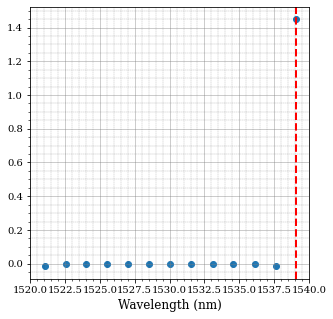

array([[1.206788e-03],
       [4.008058e-01],
       [3.013944e-03],
       [6.287392e-06],
       [7.478065e-06],
       [3.929430e-06],
       [5.581554e-06],
       [4.780528e-06],
       [5.390532e-06],
       [5.899050e-06],
       [5.080763e-06],
       [2.549136e-06],
       [4.744281e-06]])
1537.6000000000001


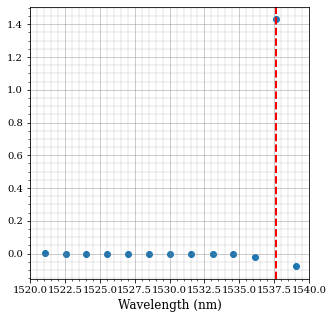

array([[4.757805e-05],
       [1.457124e-03],
       [4.905222e-01],
       [2.366876e-03],
       [4.490596e-06],
       [5.834303e-06],
       [4.484634e-06],
       [4.597442e-06],
       [4.261127e-06],
       [5.052999e-06],
       [5.836237e-06],
       [4.946472e-06],
       [4.534276e-06]])
1536.114583


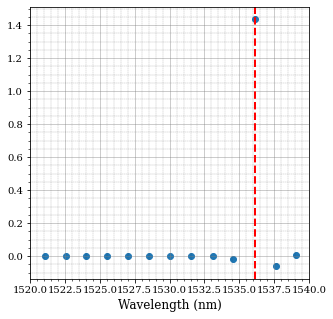

array([[2.871791e-06],
       [2.910745e-05],
       [1.325854e-03],
       [5.711227e-01],
       [2.567646e-03],
       [7.365706e-06],
       [5.936002e-06],
       [3.712699e-06],
       [4.829348e-06],
       [3.297579e-06],
       [4.646294e-06],
       [5.551932e-06],
       [3.891174e-06]])
1534.564583


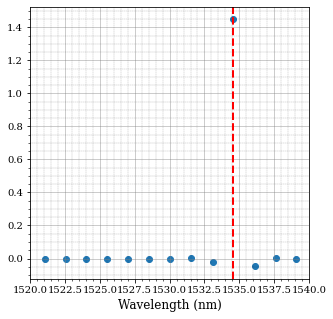

array([[1.794068e-06],
       [1.093002e-06],
       [2.189932e-05],
       [1.703809e-03],
       [6.300905e-01],
       [1.968548e-03],
       [6.544256e-06],
       [4.776461e-06],
       [3.795076e-06],
       [3.704191e-06],
       [2.842986e-06],
       [3.880962e-06],
       [4.188789e-06]])
1533.0791669999999


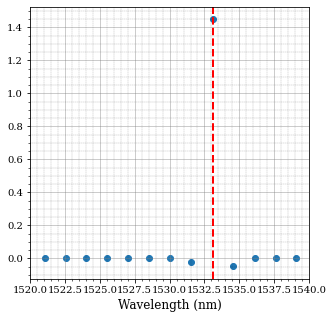

array([[2.055938e-06],
       [2.549830e-06],
       [1.074997e-06],
       [1.753890e-05],
       [1.544122e-03],
       [6.674941e-01],
       [2.137998e-03],
       [9.694360e-06],
       [3.200141e-06],
       [3.760756e-06],
       [3.346132e-06],
       [2.077701e-06],
       [2.168842e-06]])
1531.529167


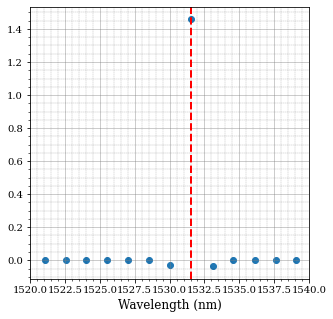

array([[1.425239e-06],
       [3.486986e-06],
       [3.510436e-06],
       [1.796519e-06],
       [1.428833e-05],
       [1.927079e-03],
       [6.795398e-01],
       [1.609981e-03],
       [1.318951e-05],
       [1.973718e-06],
       [3.725916e-06],
       [3.305886e-06],
       [1.395791e-06]])
1530.0437499999998


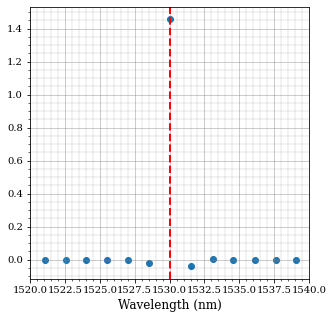

array([[2.435772e-06],
       [2.053810e-06],
       [3.131791e-06],
       [3.916537e-06],
       [3.321067e-06],
       [8.684566e-06],
       [1.736163e-03],
       [6.666326e-01],
       [1.885548e-03],
       [1.919795e-05],
       [8.652300e-07],
       [2.285626e-06],
       [2.147137e-06]])
1528.49375


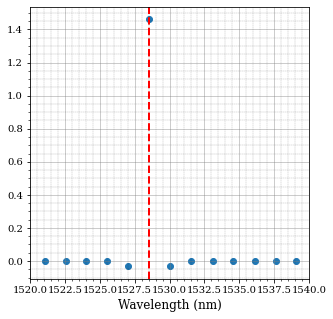

array([[4.196528e-06],
       [3.707324e-06],
       [2.863407e-06],
       [3.825431e-06],
       [3.707690e-06],
       [4.757983e-06],
       [6.921092e-06],
       [2.202026e-03],
       [6.308868e-01],
       [1.538645e-03],
       [2.062580e-05],
       [1.335238e-06],
       [1.926878e-06]])
1527.0083330000002


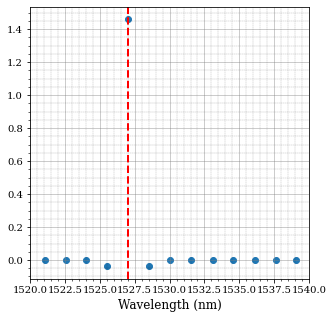

array([[3.881963e-06],
       [5.554965e-06],
       [4.601215e-06],
       [3.299768e-06],
       [4.844931e-06],
       [3.705830e-06],
       [5.933546e-06],
       [7.431639e-06],
       [2.634691e-03],
       [5.709273e-01],
       [1.297226e-03],
       [2.871941e-05],
       [2.918000e-06]])
1525.522917


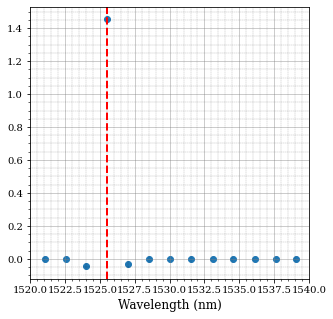

array([[3.799628e-06],
       [5.173367e-06],
       [5.999910e-06],
       [4.739704e-06],
       [4.295234e-06],
       [4.746234e-06],
       [4.406342e-06],
       [5.739425e-06],
       [5.047227e-06],
       [3.112720e-03],
       [4.899621e-01],
       [1.147949e-03],
       [4.217392e-05]])
1524.0375


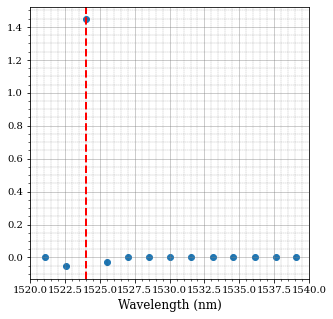

array([[5.079876e-06],
       [2.454333e-06],
       [5.230628e-06],
       [5.983929e-06],
       [5.276023e-06],
       [4.773916e-06],
       [5.568166e-06],
       [3.913769e-06],
       [7.671400e-06],
       [6.485964e-06],
       [3.366653e-03],
       [4.002937e-01],
       [1.083912e-03]])
1522.552083


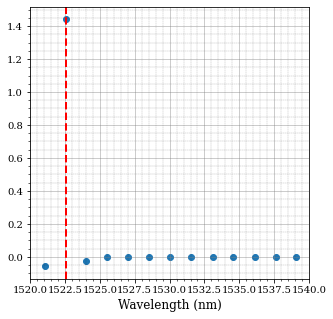

array([[1.416707e-04],
       [8.011257e-06],
       [6.099415e-06],
       [2.532799e-06],
       [6.882800e-06],
       [5.632059e-06],
       [5.369446e-06],
       [4.823276e-06],
       [3.622249e-06],
       [6.176432e-06],
       [2.911924e-06],
       [2.977334e-03],
       [3.164347e-01]])
1521.0666669999998


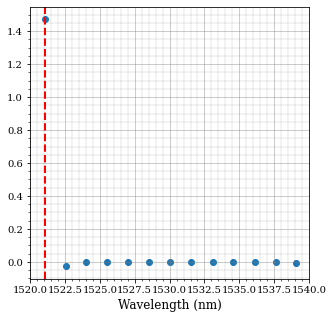

'\nfor iteration in list(range(2, total_matrices+1)):\n    square_matrix = df.iloc[channels*(iteration-1):channels*iteration, 1:channels+1]\n    print(square_matrix)\n    inverse_matrices[iteration-1] = inv(square_matrix)\n    \nTODO - get the appropriate elements from the dataframe (loop through by column, get the peaks and 3dB widths), \nthen use that to get the rows! \nI can just get the peaks, make an emission line that spans from -7.nm to +.7nm\n'

In [69]:
#Attempting to calculate the calibration matrix
'''
I'll just integrate the transmission around each peak from peak-.7nm to peak+.7nm 
then make that into square matrix, invert it, and then I'll have the calibration matrix.
I think this is equivalent to having an unnormalized emission line span from peak-3dBwidth to peak+3dBwidth
Now this codeblock makes the calibration matrix
'''
from numpy.linalg import inv
channels = 13
total_matrices = int(df.shape[0]/df.shape[1])+1
inverse_matrices = np.empty(total_matrices)
lam = np.array(df['0'])
channel_array = np.array(list(range(channels)))+1
calibration_matrix = pd.DataFrame(data = np.ndarray(shape=(13,13), dtype=float, order='C'), 
                                   columns = channel_array)
for channel in channel_array:
    op_power_norm_fib = np.array(df[str(channel)])
    FSR = 20 # nm
    peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
    emission_line = Emission_line(peak_lam[0], 1.4, 1, "Rectangular", True, 0, 0)
    emission_line.calculate_power_vs_channels(channel_array)
    calibration_matrix.iloc[channel-1, 0:13] = emission_line.integrated_power
    calibration_matrix = calibration_matrix.rename(index = {channel-1 : str(np.around(peak_lam[0], 4))})
#print(calibration_matrix)
inverted_matrix = linalg.inv(calibration_matrix)
#pprint.pprint(inverted_matrix)

def test_calibration_matrix(center_nanometer, offset):
    emission_line = Emission_line(center_nanometer+offset, .1, 1, "Rectangular", True, 0, 0)
    emission_line.calculate_power_vs_channels(channel_array)
    observation_matrix = np.array([emission_line.integrated_power])
    observation_matrix = observation_matrix.T
    pprint.pprint(observation_matrix)
    retrieved_spectrum = np.matmul(inverted_matrix, observation_matrix)
    retrieved_spectrum = pd.DataFrame(data = retrieved_spectrum, index = calibration_matrix.index)
    source_wavelengths = df.iloc[emission_line.row_indices_spanned,0]
    source_wavelengths = source_wavelengths.to_numpy()
    source_spectrum = pd.DataFrame(data = emission_line.source_power, index = source_wavelengths)
    #pprint.pprint(retrieved_spectrum)
    #pprint.pprint(source_spectrum) 
    #print(peak_lam[0]-2,peak_lam[len(peak_lam)-1]+2)
    #plt.xlim(peak_lam[0]-2,peak_lam[len(peak_lam)-1]+10)
    fig, ax = plt.subplots(figsize=(5,5))
    ax = plt.gca() #get current axis
    x = retrieved_spectrum.index
    x = np.array(x, dtype = 'float')
    y = retrieved_spectrum.iloc[0:retrieved_spectrum.shape[0]]
    y = y.to_numpy()
    ax.scatter(x, y)
    print(center_nanometer+offset)
    ax.axvline(x = center_nanometer+offset, linestyle='dashed', color = 'r', linewidth = 2)
    ax.set_xlim(xmin = 1520, xmax = 1540)
    ax.minorticks_on()
    ax.tick_params(axis='y', which='both')
    ax.tick_params(axis='y', which='minor')
    ax.grid(which='minor', linestyle=':', linewidth='0.25', color='black')
    ax.grid(which='major', color='grey', alpha=0.5)
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    plt.show()

for channel in channel_array:
    offset = 0
    op_power_norm_fib = np.array(df[str(channel)])
    peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
    center_nanometer = peak_lam[0]
    test_calibration_matrix(peak_lam[0], offset)


'''
for iteration in list(range(2, total_matrices+1)):
    square_matrix = df.iloc[channels*(iteration-1):channels*iteration, 1:channels+1]
    print(square_matrix)
    inverse_matrices[iteration-1] = inv(square_matrix)
    
TODO - get the appropriate elements from the dataframe (loop through by column, get the peaks and 3dB widths), 
then use that to get the rows! 
I can just get the peaks, make an emission line that spans from -7.nm to +.7nm
'''


#All of the rows are identical! weird. Maybe I'll just make square matrices of all of the linearly independent rows?
#In the first column, the transmission changes value 621 times. 


In [15]:
#End of what Marcos has written for now

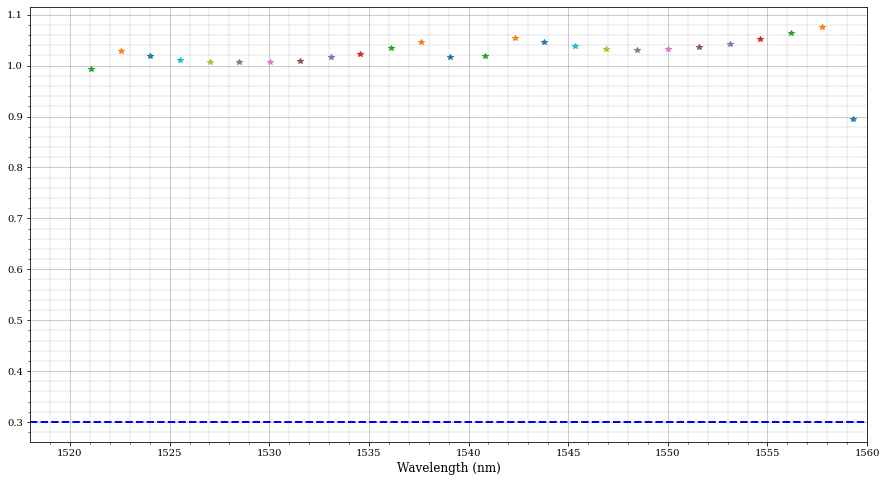

In [16]:
fig, ax = plt.subplots(figsize=(15,8))

for i in range(1,chan_num+1):
    lam = np.array(df['0'])
    op_power_norm_fib = np.array(df[str(i)])
    FSR = 20 # nm
    peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
    #plt.plot(lam, op_power_norm_fib)
    #plt.plot(peak_lam, peak_power, 'b*')
    plt.plot(peak_lam, peak_width, '*')
    

    
ax.minorticks_on()
ax.tick_params(axis='y', which='both')
#ax.grid(which='both')
plt.axhline(y=0.3, linestyle='dashed', color = 'b', linewidth = 2)

#ax = plt.gca()
ax.tick_params(axis='y', which='minor')
ax.grid(which='minor', linestyle=':', linewidth='0.25', color='black')
ax.grid(which='major', color='grey', alpha=0.5)
ax.set_xlabel('Wavelength (nm)', fontsize=12)

plt.xlim(1518, 1560)  
#plt.ylim(0, 0.75)
#this plot doesn't quite look right. Ask Pradip about it.
#It is fine. This was also used for a specotrgraph with higher spectral resolution
plt.show()
#one point for each channel in each spectral order.

# Plot Spectral Dropout as a function of Resolving power

In [17]:
def get_spectral_dropout(df, probe_channels, FSR, chan_num):
    peak_lam_array = []
    spec_dropout_array = []
    peak_power_array = []
    
    a = np.arange(1, chan_num+1)
    a_string = [str(a_i) for a_i in a] 
    df2 = np.power(10.0, df[a_string]/10.0)
    spectral_sum = np.array(10*np.log10(df2.sum(axis=1)))
    
    for i in probe_channels: #range(1,chan_num+1):  # No need to do this for all the channels, just do it for the central on and edge one
        lam = np.array(df['0'])
        
        op_power_norm_fib = np.array(df[str(i-1)])
        peak_ind_left, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        op_power_norm_fib = np.array(df[str(i+1)])
        peak_ind_right, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        op_power_norm_fib = np.array(df[str(i)])
        peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        
        
        peak_power = np.max(peak_power)
        peak_ind = np.max(peak_ind)
        peak_ind_left = np.max(peak_ind_left)
        peak_ind_right = np.max(peak_ind_right)
        
        left_ind = np.min([peak_ind_left, peak_ind, peak_ind_right])
        ind = peak_ind
        right_ind = np.max([peak_ind_left, peak_ind, peak_ind_right])
        
        droupout_left = spectral_sum[peak_ind] - np.min(spectral_sum[left_ind:ind]) 
        droupout_right = spectral_sum[peak_ind] - np.min(spectral_sum[ind:right_ind])
        dropout =  0.5*(droupout_left + droupout_right)
        
        
        peak_lam_array.append(np.max(peak_lam)) # Taking max to ensure only one peak_lam is sent for one channel
        spec_dropout_array.append(dropout)
        peak_power_array.append(peak_power)
    
    return np.array(peak_lam_array), np.array(spec_dropout_array), np.array(peak_power_array)
    


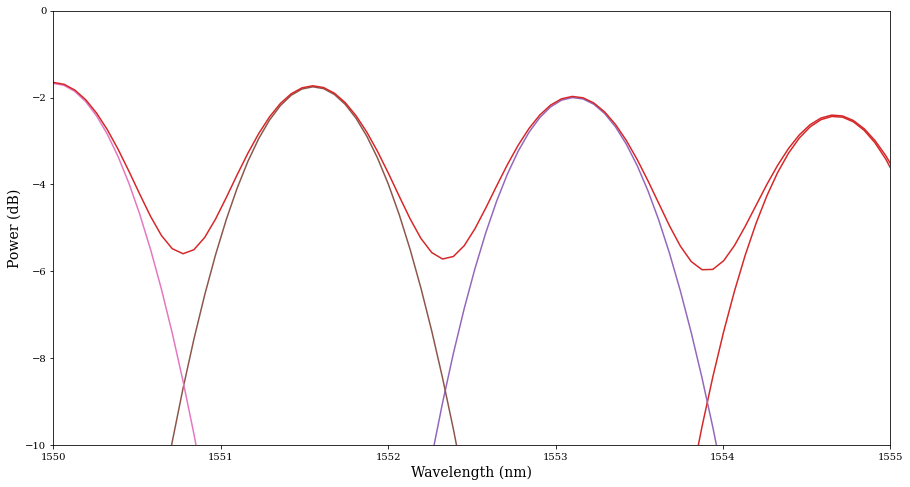

In [18]:
a = np.arange(1, chan_num+1)
a_string = [str(a_i) for a_i in a] 

df2 = np.power(10.0, df[a_string]/10.0)
spectral_sum = 10*np.log10(df2.sum(axis=1))


fig, ax = plt.subplots(figsize=(15,8))
df.plot(x='0', legend=0, ax = ax)
ax.plot(df['0'], spectral_sum)

ax.set_xlabel('Wavelength (nm)', fontsize=14)
ax.set_ylabel('Power (dB)', fontsize=14)
ax.set_xlim(1550, 1555)
ax.set_ylim(-10, 0)

plt.show()